In [1]:
# pip install git+https://github.com/xunzheng/notears.git

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from notears.linear import notears_linear
import networkx as nx
import matplotlib.pyplot as plt

# 데이터 전처리
df = pd.read_csv("training_data.csv")
# X = df.values
# label 제거 필요
X = df.drop(columns=["Unnamed: 0", "label"]).values
X = StandardScaler().fit_transform(X)

# NOTEARS 실행
W = notears_linear(X, lambda1=0.1, loss_type='l2')  # lambda1으로 sparsity 조절

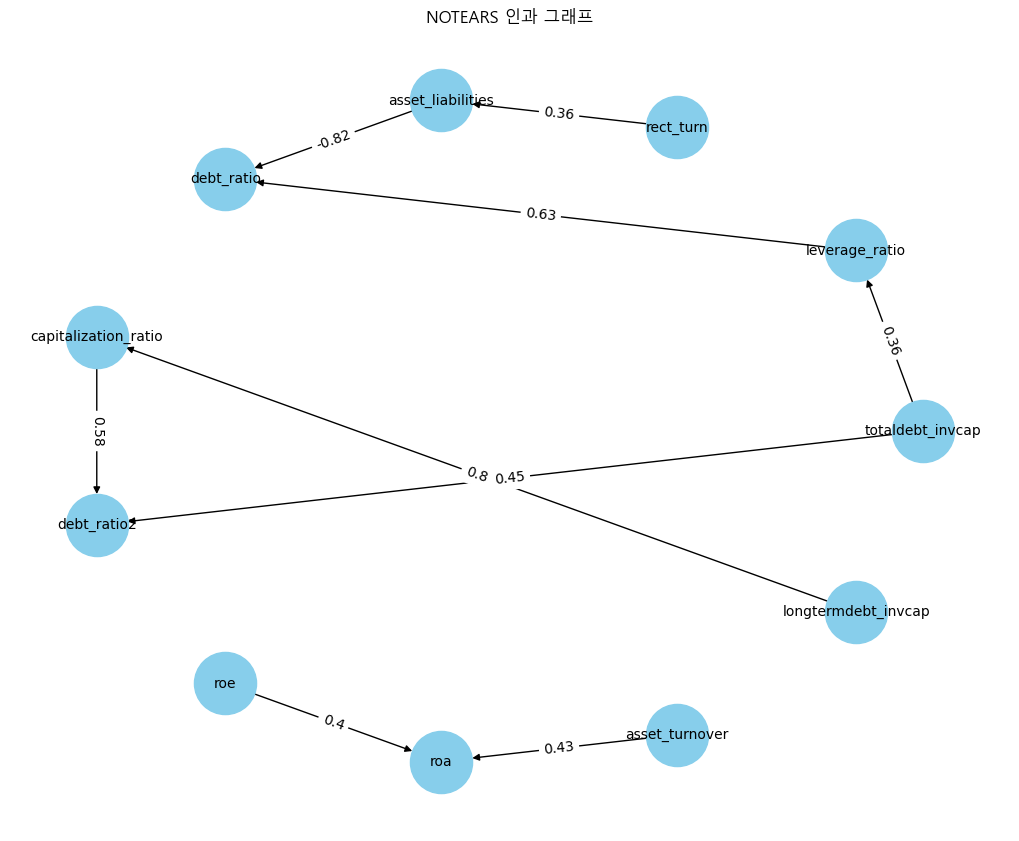

In [3]:
import matplotlib
import matplotlib.pyplot as plt

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 기호 깨짐 방지
matplotlib.rcParams['axes.unicode_minus'] = False


# 인과 그래프 시각화
cols = df.columns[1:-1]  # label 제외한 열 이름
G = nx.DiGraph()

for i in range(len(cols)):
    for j in range(len(cols)):
        if abs(W[i, j]) > 0.01:  # threshold 적용(0 제외)
            G.add_edge(cols[j], cols[i], weight=round(W[i, j], 2))

plt.figure(figsize=(10, 8))
# pos = nx.spring_layout(G)
# pos = nx.shell_layout(G)
# pos = nx.kamada_kawai_layout(G)
pos = nx.circular_layout(G)

nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=10)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'weight'))
plt.title("NOTEARS 인과 그래프")
plt.show()


In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# Load dataset
df = pd.read_csv('./training_data.csv')
X_base = df.drop(columns=["Unnamed: 0", "label"])
y = df["label"]
cols = X_base.columns.tolist()

# Set threshold for significant edges
threshold = 0.3

def generate_features(X_base, cols, W, mode):
    new_features = pd.DataFrame(index=X_base.index)

    for i in range(len(cols)):
        for j in range(len(cols)):
            w_ij = W[i, j]
            if abs(w_ij) > threshold:
                A = cols[j]
                B = cols[i]
                mul = X_base[A] * X_base[B]
                sub = X_base[A] - X_base[B]

                if mode == "original":
                    continue
                elif mode == "mul":
                    new_features[f"{A}_mul_{B}"] = mul
                elif mode == "sub":
                    new_features[f"{A}_sub_{B}"] = sub
                elif mode == "mul*w":
                    new_features[f"{A}_mulw_{B}"] = w_ij * mul
                elif mode == "sub*w":
                    new_features[f"{A}_subw_{B}"] = w_ij * sub
                elif mode == "mul+sub":
                    new_features[f"{A}_mul_{B}"] = mul
                    new_features[f"{A}_sub_{B}"] = sub
                elif mode == "mul+mul*w":
                    new_features[f"{A}_mul_{B}"] = mul
                    new_features[f"{A}_mulw_{B}"] = w_ij * mul
                elif mode == "mul+sub*w":
                    new_features[f"{A}_mul_{B}"] = mul
                    new_features[f"{A}_subw_{B}"] = w_ij * sub
                elif mode == "sub+mul*w":
                    new_features[f"{A}_sub_{B}"] = sub
                    new_features[f"{A}_mulw_{B}"] = w_ij * mul
                elif mode == "sub+sub*w":
                    new_features[f"{A}_sub_{B}"] = sub
                    new_features[f"{A}_subw_{B}"] = w_ij * sub
                elif mode == "mul*w+sub*w":
                    new_features[f"{A}_mulw_{B}"] = w_ij * mul
                    new_features[f"{A}_subw_{B}"] = w_ij * sub
                elif mode == "mul+mul*w+sub*w":
                    new_features[f"{A}_mul_{B}"] = mul
                    new_features[f"{A}_mulw_{B}"] = w_ij * mul
                    new_features[f"{A}_subw_{B}"] = w_ij * sub
                elif mode == "mul+sub+mul*w":
                    new_features[f"{A}_mul_{B}"] = mul
                    new_features[f"{A}_sub_{B}"] = sub
                    new_features[f"{A}_mulw_{B}"] = w_ij * mul
                elif mode == "mul+sub+sub*w":
                    new_features[f"{A}_mul_{B}"] = mul
                    new_features[f"{A}_sub_{B}"] = sub
                    new_features[f"{A}_subw_{B}"] = w_ij * sub
                elif mode == "sub+mul*w+sub*w":
                    new_features[f"{A}_sub_{B}"] = sub
                    new_features[f"{A}_mulw_{B}"] = w_ij * mul
                    new_features[f"{A}_subw_{B}"] = w_ij * sub
                elif mode == "mul+sub+mul*w+sub*w":
                    new_features[f"{A}_mul_{B}"] = mul
                    new_features[f"{A}_sub_{B}"] = sub
                    new_features[f"{A}_mulw_{B}"] = w_ij * mul
                    new_features[f"{A}_subw_{B}"] = w_ij * sub

    return pd.concat([X_base, new_features], axis=1)



# Define all 16 modes
modes = [
    "original",              # 0개 생성
    "mul",                   # 1개 (곱)
    "sub",                   # 1개 (차)
    "mul*w",                 # 1개 (가중 곱)
    "sub*w",                 # 1개 (가중 차)
    "mul+sub",               # 2개 (곱, 차)
    "mul+mul*w",             # 2개 (곱, 가중 곱)
    "mul+sub*w",             # 2개 (곱, 가중 차)
    "sub+mul*w",             # 2개 (차, 가중 곱)
    "sub+sub*w"              # 2개 (차, 가중 차)
    "mul*w+sub*w",           # 2개 (가중 곱, 가중 차)
    "mul+mul*w+sub*w",       # 3개 (곱, 가중 곱, 가중 차)
    "mul+sub+mul*w",         # 3개 (곱, 차, 가중 곱)
    "mul+sub+sub*w",         # 3개 (곱, 차, 가중 차)
    "sub+mul*w+sub*w",       # 3개 (차, 가중 곱, 가중 차)
    "mul+sub+mul*w+sub*w",   # 4개 (곱, 차, 가중 곱, 가중 차)
]
# Store results
results = {}

for mode in modes:
    X = generate_features(X_base, cols, W, mode)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

    model = XGBClassifier(
        use_label_encoder=False,
        eval_metric="logloss",
        scale_pos_weight=scale_pos_weight,
        random_state=42
    )
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    report = classification_report(y_test, y_pred, output_dict=True)
    results[mode] = pd.DataFrame(report).transpose().round(3)

c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [12:28:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\User\AppData\Local\Temp\ipykernel_19428\1710332133.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_features[f"{A}_mul_{B}"] = mul
C:\Users\User\AppData\Local\Temp\ipykernel_19428\1710332133.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=

c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [12:37:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\User\AppData\Local\Temp\ipykernel_19428\1625607689.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_features[f"{A}_mul_{B}"] = mul
C:\Users\User\AppData\Local\Temp\ipykernel_19428\1625607689.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=

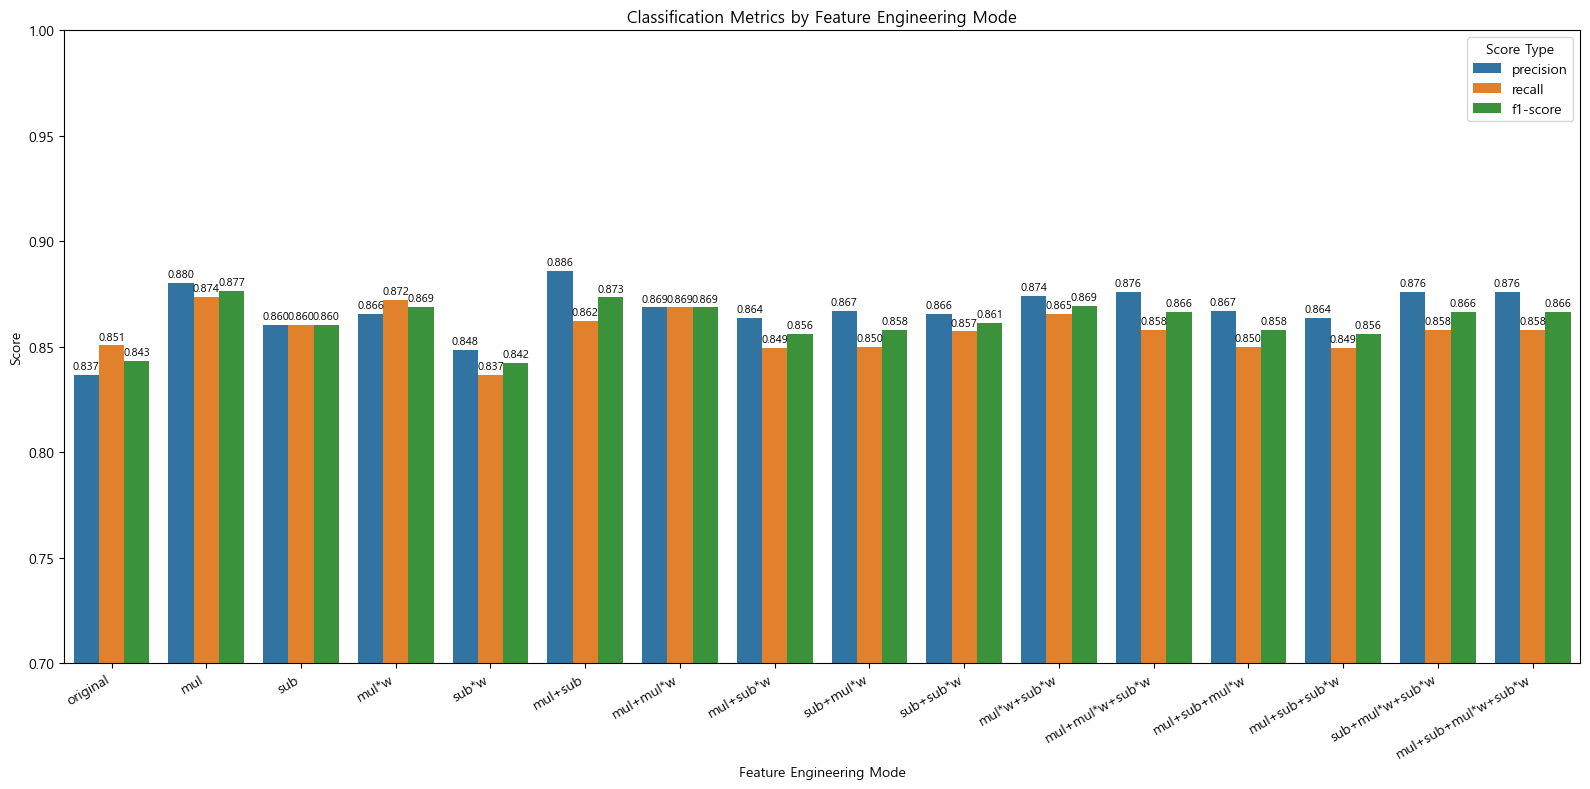

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# Load dataset
df = pd.read_csv('./training_data.csv')
X_base = df.drop(columns=["Unnamed: 0", "label"])
y = df["label"]
cols = X_base.columns.tolist()

# Generate simulated NOTEARS W matrix
np.random.seed(0)
W = np.random.uniform(-1, 1, size=(len(cols), len(cols)))

# Set threshold for significant weights
threshold = 0.3

# Updated mode list (with proper comma placement to avoid string concatenation bugs)
modes = [
    "original", "mul", "sub", "mul*w", "sub*w",
    "mul+sub", "mul+mul*w", "mul+sub*w", "sub+mul*w", "sub+sub*w",
    "mul*w+sub*w", "mul+mul*w+sub*w", "mul+sub+mul*w", "mul+sub+sub*w",
    "sub+mul*w+sub*w", "mul+sub+mul*w+sub*w"
]

# Feature generation function
def generate_features(X_base, cols, W, mode):
    new_features = pd.DataFrame(index=X_base.index)

    for i in range(len(cols)):
        for j in range(len(cols)):
            w_ij = W[i, j]
            if abs(w_ij) > threshold:
                A = cols[j]
                B = cols[i]
                mul = X_base[A] * X_base[B]
                sub = X_base[A] - X_base[B]

                if "mul" in mode and "+mul*" not in mode:
                    new_features[f"{A}_mul_{B}"] = mul
                if "sub" in mode and "+sub*" not in mode:
                    new_features[f"{A}_sub_{B}"] = sub
                if "mul*w" in mode:
                    new_features[f"{A}_mulw_{B}"] = w_ij * mul
                if "sub*w" in mode:
                    new_features[f"{A}_subw_{B}"] = w_ij * sub

    return pd.concat([X_base, new_features], axis=1)

# Train and evaluate models for each mode
results = {}
for mode in modes:
    X = generate_features(X_base, cols, W, mode)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

    model = XGBClassifier(
        use_label_encoder=False,
        eval_metric="logloss",
        scale_pos_weight=scale_pos_weight,
        random_state=42
    )
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    report = classification_report(y_test, y_pred, output_dict=True)
    results[mode] = pd.DataFrame(report).transpose().round(3)



C:\Users\User\AppData\Local\Temp\ipykernel_19428\2864599332.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=plot_melted, x="mode", y="value", hue="score_type", ci=None)


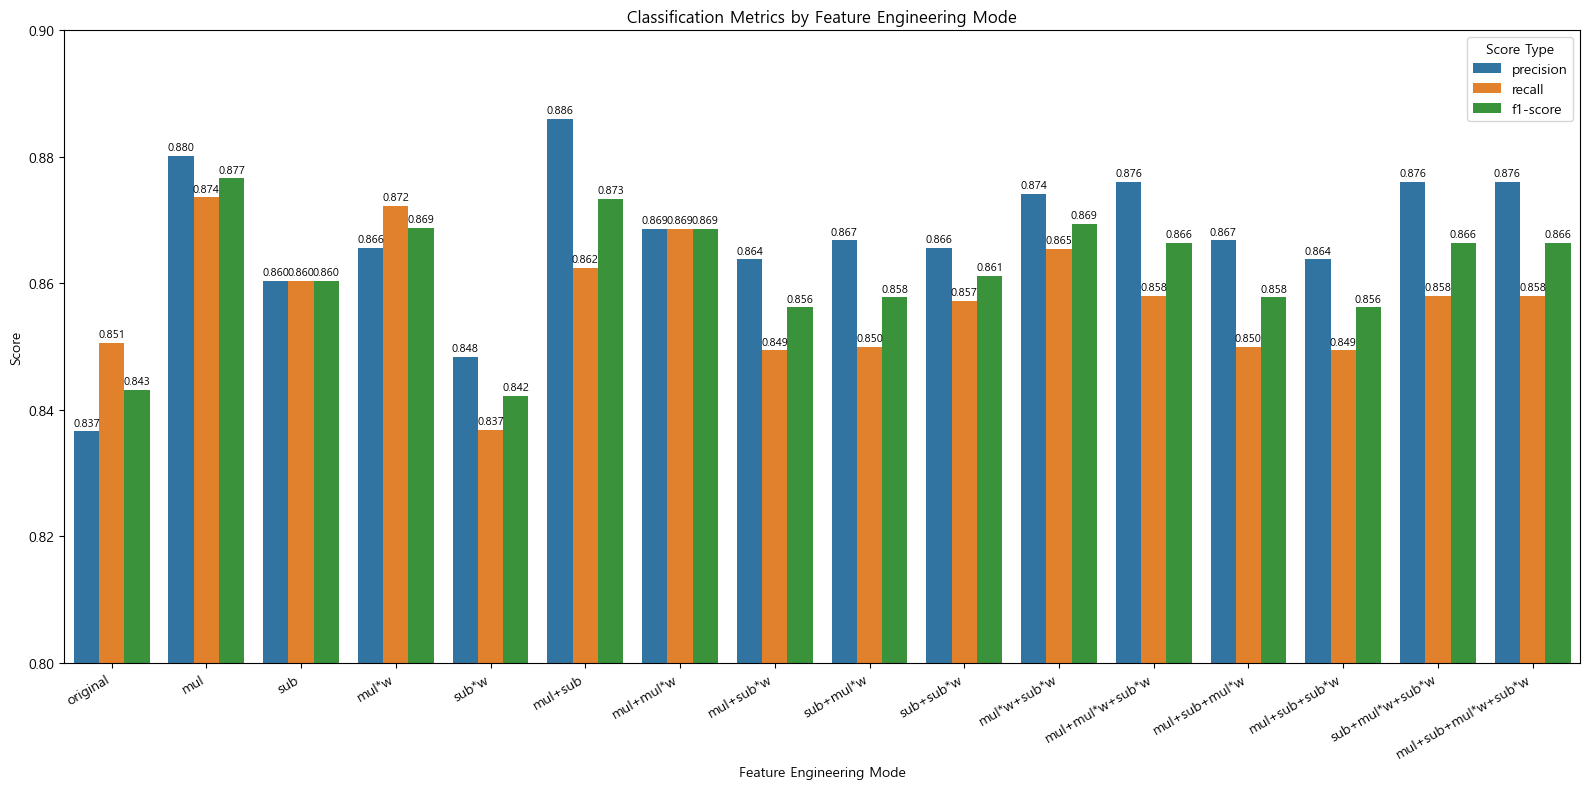

In [49]:
# Flatten results for plotting
flat_results = []
for mode, df in results.items():
    df = df.copy()
    df["metric"] = df.index
    df["mode"] = mode
    flat_results.append(df)

full_results = pd.concat(flat_results, ignore_index=True)

# Filter relevant metrics
plot_df = full_results[["mode", "metric", "precision", "recall", "f1-score"]]
plot_df = plot_df[plot_df["metric"].isin(["0", "1", "accuracy", "macro avg", "weighted avg"])]

# Melt for seaborn
plot_melted = plot_df.melt(id_vars=["mode", "metric"], 
                           value_vars=["precision", "recall", "f1-score"], 
                           var_name="score_type", 
                           value_name="value")

# Plot
plt.figure(figsize=(16, 8))
ax = sns.barplot(data=plot_melted, x="mode", y="value", hue="score_type", ci=None)

# Annotate values
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', label_type='edge', padding=2, fontsize=8)

plt.title("Classification Metrics by Feature Engineering Mode")
plt.ylabel("Score")
plt.xlabel("Feature Engineering Mode")
plt.xticks(rotation=30, ha='right')
plt.ylim(0.8, 0.9)
plt.legend(title="Score Type")
plt.tight_layout()
plt.show()

In [ ]:
# 모든 조합 feature 추가 엑셀화

import pandas as pd
import numpy as np

# 데이터 불러오기
df = pd.read_csv('./training_data.csv')
X_base = df.drop(columns=["Unnamed: 0", "label"])
y = df["label"]
cols = X_base.columns.tolist()

# NOTEARS 가중치 W 행렬 (예시로 난수 생성)
np.random.seed(0)
W = np.random.uniform(-1, 1, size=(len(cols), len(cols)))
threshold = 0.3

# 피처 생성 함수
def generate_features(X_base, cols, W, mode):
    new_features = pd.DataFrame(index=X_base.index)
    for i in range(len(cols)):
        for j in range(len(cols)):
            w_ij = W[i, j]
            if abs(w_ij) > threshold:
                A = cols[j]
                B = cols[i]
                mul = X_base[A] * X_base[B]
                sub = X_base[A] - X_base[B]
                if "mul" in mode:
                    new_features[f"{A}_mul_{B}"] = mul
                if "sub" in mode:
                    new_features[f"{A}_sub_{B}"] = sub
                if "mul*w" in mode:
                    new_features[f"{A}_mulw_{B}"] = w_ij * mul
                if "sub*w" in mode:
                    new_features[f"{A}_subw_{B}"] = w_ij * sub
    return pd.concat([X_base, new_features], axis=1)

# mode 조합
mode = "mul+sub+mul*w+sub*w"

# 피처 생성
X_extended = generate_features(X_base, cols, W, mode)

# (선택적으로) 샘플 일부만 저장
X_sampled = X_extended.head(100)  # 또는 전체 사용: X_extended

# Excel 저장
X_sampled.to_csv("features_extended_mul_sub_weighted.csv", index=False)


C:\Users\User\AppData\Local\Temp\ipykernel_19428\311713895.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_features[f"{A}_mul_{B}"] = mul
C:\Users\User\AppData\Local\Temp\ipykernel_19428\311713895.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_features[f"{A}_sub_{B}"] = sub
C:\Users\User\AppData\Local\Temp\ipykernel_19428\311713895.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

In [ ]:
# mul feature 추가 엑셀화

import pandas as pd
import numpy as np

# 데이터 불러오기
df = pd.read_csv('./training_data.csv')
X_base = df.drop(columns=["Unnamed: 0", "label"])
y = df["label"]
cols = X_base.columns.tolist()

# NOTEARS 가중치 W 행렬 (예시로 난수 생성)
np.random.seed(0)
W = np.random.uniform(-1, 1, size=(len(cols), len(cols)))
threshold = 0.3

# 피처 생성 함수
def generate_features(X_base, cols, W, mode):
    new_features = pd.DataFrame(index=X_base.index)
    for i in range(len(cols)):
        for j in range(len(cols)):
            w_ij = W[i, j]
            if abs(w_ij) > threshold:
                A = cols[j]
                B = cols[i]
                mul = X_base[A] * X_base[B]
                sub = X_base[A] - X_base[B]
                if "mul" in mode:
                    new_features[f"{A}_mul_{B}"] = mul
    return pd.concat([X_base, new_features], axis=1)

# mode 조합
mode = "mul"

# 피처 생성
X_extended = generate_features(X_base, cols, W, mode)

# (선택적으로) 샘플 일부만 저장
X_sampled = X_extended.head(100)  # 또는 전체 사용: X_extended

# Excel 저장
X_sampled.to_csv("features_extended_mul.csv", index=False)


C:\Users\User\AppData\Local\Temp\ipykernel_19428\1024962831.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_features[f"{A}_mul_{B}"] = mul
C:\Users\User\AppData\Local\Temp\ipykernel_19428\1024962831.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_features[f"{A}_mul_{B}"] = mul
C:\Users\User\AppData\Local\Temp\ipykernel_19428\1024962831.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all col